In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
customer_transactions = transactions.merge(customers, on='CustomerID', how='left')
print(customer_transactions.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


# Aggregate transaction data to create customer profiles

In [3]:
customer_profiles = customer_transactions.groupby('CustomerID').agg({
    'Region': 'first',  
    'TotalValue': 'sum',  
    'Quantity': 'sum',  
    'ProductID': 'nunique' 
}).reset_index()

print(customer_profiles.head())

  CustomerID         Region  TotalValue  Quantity  ProductID
0      C0001  South America     3354.52        12          5
1      C0002           Asia     1862.74        10          4
2      C0003  South America     2725.38        14          4
3      C0004  South America     5354.88        23          8
4      C0005           Asia     2034.24         7          3


# Normalize the features for clustering

In [4]:
scaler = StandardScaler()
customer_profiles[['TotalValue', 'Quantity', 'ProductID']] = scaler.fit_transform(customer_profiles[['TotalValue', 'Quantity', 'ProductID']])
print(customer_profiles.head())

  CustomerID         Region  TotalValue  Quantity  ProductID
0      C0001  South America   -0.061701 -0.122033   0.050047
1      C0002           Asia   -0.877744 -0.448000  -0.424204
2      C0003  South America   -0.405857  0.203934  -0.424204
3      C0004  South America    1.032547  1.670787   1.472798
4      C0005           Asia   -0.783929 -0.936951  -0.898455


# Clustering with KMeans

In [7]:
db_index_values = []
for k in range(3, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles[['TotalValue', 'Quantity', 'ProductID']])
    db_index = davies_bouldin_score(customer_profiles[['TotalValue', 'Quantity', 'ProductID']], customer_profiles['Cluster'])
    db_index_values.append(db_index)
optimal_k = db_index_values.index(min(db_index_values)) + 3
print(f"Optimal number of clusters: {optimal_k}")


Optimal number of clusters: 3


# Apply KMeans with Optimal Clusters

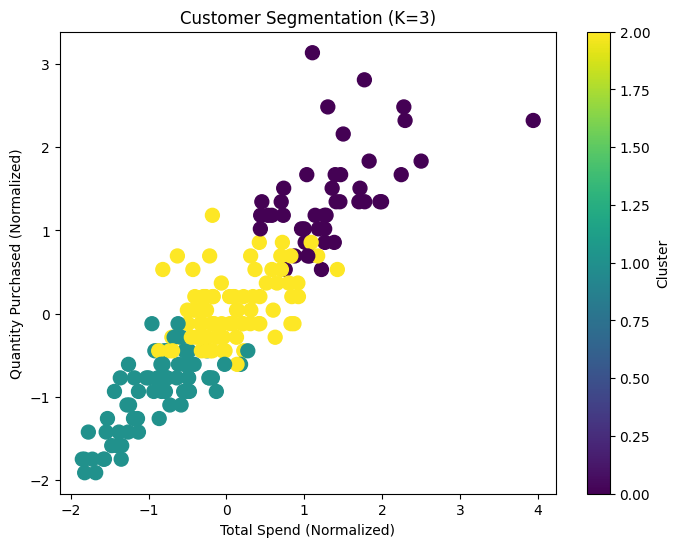

In [8]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles[['TotalValue', 'Quantity', 'ProductID']])
plt.figure(figsize=(8, 6))
plt.scatter(customer_profiles['TotalValue'], customer_profiles['Quantity'], c=customer_profiles['Cluster'], cmap='viridis', s=100)
plt.title(f'Customer Segmentation (K={optimal_k})')
plt.xlabel('Total Spend (Normalized)')
plt.ylabel('Quantity Purchased (Normalized)')
plt.colorbar(label='Cluster')
plt.show()


# Clustering Metrics

In [9]:
db_index = davies_bouldin_score(customer_profiles[['TotalValue', 'Quantity', 'ProductID']], customer_profiles['Cluster'])
print(f"Davies-Bouldin Index for optimal clusters: {db_index}")
print(f"Inertia (Sum of squared distances): {kmeans.inertia_}")


Davies-Bouldin Index for optimal clusters: 0.7962864060880129
Inertia (Sum of squared distances): 157.0369822590883
